In [3]:
# ‚ñ† ÂÆåÂÖ®ÂâçÂá¶ÁêÜ„Çª„É´ÔºàNotebook „ÅÆÊúÄÂàù„Å´‰∏ÄÂ∫¶„Å†„ÅëÂÆüË°åÔºâ

import pandas as pd
import numpy as np

# ---- „É¶„Éº„ÉÜ„Ç£„É™„ÉÜ„Ç£Ôºö„Ç´„ÉÜ„Ç¥„É™Âàó„ÅÆÊï¥Êï∞„Ç≥„Éº„ÉâÂåñÔºàtrainÂü∫Ê∫ñ„Åßtest„ÇíÂêà„Çè„Åõ„ÇãÔºâ ----
def encode_categories(df, cat_cols, cats_dict=None, return_cats=False):
    """
    df[cat_cols] „Çí pd.Categorical(...).codes „ÅßÊï¥Êï∞Âåñ„Åô„Çã„ÄÇ
    cats_dict „ÇíÊ∏°„Åô„Å®„ÄÅ„Åù„ÅÆ„Ç´„ÉÜ„Ç¥„É™È†Ü„Å´Âêà„Çè„Åõ„Å¶Á¨¶Âè∑ÂåñÔºàtestÂÅ¥„Åß‰ΩøÁî®Ôºâ„ÄÇ
    return_cats=True „ÅÆ„Å®„Åç (df, cats_dict) „ÇíËøî„Åô„ÄÇ
    """
    if cats_dict is None:
        cats_dict = {}
        for c in cat_cols:
            cats = pd.Categorical(df[c]).categories
            cats_dict[c] = list(cats)

    for c in cat_cols:
        cats = cats_dict[c]
        df[c] = pd.Categorical(df[c], categories=cats).codes  # Êú™Áü•„Ç´„ÉÜ„Ç¥„É™/NaN „ÅØ -1
    return (df, cats_dict) if return_cats else df

# 1. „Éá„Éº„ÇøË™≠„ÅøËæº„Åø
DATA_DIR = r"G:\„Éû„Ç§„Éâ„É©„Ç§„Éñ\MUFJ_competition_2025\data"
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/test.csv")

# 2. ÂØæÊï∞Â§âÊèõ (log1p)
for col in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']:
    train_df[f'{col}_log1p'] = np.log1p(train_df[col])
    test_df [f'{col}_log1p'] = np.log1p(test_df [col])

# 3. ÊØîÁéá„Éª‰∫§‰∫í‰ΩúÁî®ÁâπÂæ¥
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']
test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# 4. „Ç´„ÉÜ„Ç¥„É™Âûã„Ç≠„É£„Çπ„Éà
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df [c] = test_df [c].astype('category')

# 5. „Çø„Éº„Ç≤„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞ÔºàË¶≥Ê∏¨„Ç´„ÉÜ„Ç¥„É™„ÅÆË≠¶Âëä„ÇíÊäëÊ≠¢Ôºâ
te_cols     = ['Subprogram','NaicsSector','BusinessAge','BusinessType']
k_smooth    = 10
global_mean = train_df['LoanStatus'].mean()
for col in te_cols:
    agg        = train_df.groupby(col, observed=False)['LoanStatus'].agg(['count','mean'])
    counts, m  = agg['count'], agg['mean']
    smooth     = (m*counts + global_mean*k_smooth) / (counts + k_smooth)
    train_df[f'{col}_te'] = train_df[col].map(smooth)
    test_df [f'{col}_te'] = test_df[col].map(smooth).astype(float).fillna(global_mean)

# 6. È†ªÂ∫¶„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞
for col in te_cols:
    freq = train_df[col].value_counts(normalize=True)
    train_df[f'{col}_fe'] = train_df[col].map(freq).astype(float).fillna(0.0)
    test_df [f'{col}_fe'] = test_df[col].map(freq).astype(float).fillna(0.0)

# 7. ÁâπÂæ¥Èáè„É™„Çπ„ÉàÂÆöÁæ©
base_feats  = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
]
features     = base_feats + cat_cols + [f'{c}_te' for c in te_cols]
features_fe  = features    + [f'{c}_fe' for c in te_cols]

# 8. „Ç´„ÉÜ„Ç¥„É™Âàó„Ç≥„Éº„ÉâÂåñÔºàtrainÂü∫Ê∫ñ ‚Üí test„ÇÇÂêå„Åò„Ç´„ÉÜ„Ç¥„É™È†Ü„ÅßÁ¨¶Âè∑ÂåñÔºâ
train_df, cats_dict = encode_categories(train_df, cat_cols, return_cats=True)
test_df  = encode_categories(test_df,  cat_cols, cats_dict=cats_dict)

# Á¢∫Ë™ç
print("ÂâçÂá¶ÁêÜÂÆå‰∫Ü: ÁâπÂæ¥ÈáèÊï∞ =", len(features_fe))
print("ÊèÉ„ÅÑ„ÉÅ„Çß„ÉÉ„ÇØ:", all(f in train_df.columns for f in features_fe))
print("‚úÖ train_df/test_df „ÅÆ„Ç´„ÉÜ„Ç¥„É™„Ç≥„Éº„ÉâÂåñÂÆå‰∫ÜÔºàÊú™Áü•„Ç´„ÉÜ„Ç¥„É™„ÅØ -1Ôºâ")


ÂâçÂá¶ÁêÜÂÆå‰∫Ü: ÁâπÂæ¥ÈáèÊï∞ = 26
ÊèÉ„ÅÑ„ÉÅ„Çß„ÉÉ„ÇØ: True
‚úÖ train_df/test_df „ÅÆ„Ç´„ÉÜ„Ç¥„É™„Ç≥„Éº„ÉâÂåñÂÆå‰∫ÜÔºàÊú™Áü•„Ç´„ÉÜ„Ç¥„É™„ÅØ -1Ôºâ


In [4]:
# ‚ñ† „Ç´„ÉÜ„Ç¥„É™Â§âÊï∞„ÇíÊï¥Êï∞„Ç≥„Éº„ÉâÂåñ„Åô„ÇãÂÖ±ÈÄöÈñ¢Êï∞
import pandas as pd

def encode_categories(df, cat_cols):
    """
    DataFrame df „ÅÆ cat_cols „ÅßÊåáÂÆö„Åó„ÅüÂàó„Çí
    pd.Categorical(...).codes „ÅßÊï¥Êï∞„Ç≥„Éº„ÉâÂåñ„Åó„Å¶‰∏äÊõ∏„Åç„Åó„Åæ„Åô„ÄÇ
    """
    for c in cat_cols:
        df[c] = pd.Categorical(df[c]).codes
    return df

# „Ç´„ÉÜ„Ç¥„É™Âàó‰∏ÄË¶ß
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]


In [5]:
# ‚îÄ‚îÄ „Ç´„ÉÜ„Ç¥„É™Â§âÊï∞„ÇíÊï¥Êï∞„Ç≥„Éº„ÉâÂåñÔºà‰øÆÊ≠£ÁâàÔºâ‚îÄ‚îÄ
import pandas as pd

cat_cols = ['Subprogram','FixedOrVariableInterestInd','NaicsSector',
            'BusinessType','BusinessAge','CollateralInd']
for c in cat_cols:
    # pandas.Categorical „Åß„Ç´„ÉÜ„Ç¥„É™Âûã„Å´Â§âÊèõ„Åó„Å¶„Åã„Çâ .codes ÂèñÂæó
    train_df[c] = pd.Categorical(train_df[c]).codes
    test_df [c] = pd.Categorical(test_df[c]).codes

print("‚úÖ category ‚Üí codes ÂÆå‰∫ÜÔºàdtype „Å´‰æùÂ≠ò„Åõ„ÅöÂÆüË°åÔºâ")


‚úÖ category ‚Üí codes ÂÆå‰∫ÜÔºàdtype „Å´‰æùÂ≠ò„Åõ„ÅöÂÆüË°åÔºâ


In [7]:
# ‚ñ† ÂâçÂá¶ÁêÜ„Éë„Ç§„Éó„É©„Ç§„É≥Ôºà‰øÆÊ≠£ÁâàÔºöX_train ÂÆöÁæ© ‚Üí ÂàóÊåáÂÆö„Çí cat_cols „Éô„Éº„Çπ„Å´Ôºâ

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# 0) ÂâçÊèê: train_df, test_df, features_fe, cat_cols „ÅåÊó¢„Å´ÂÆöÁæ©Ê∏à„Åø
X_train = train_df[features_fe].copy()
y_train = train_df['LoanStatus'].astype(int)
X_test  = test_df[features_fe].copy()

# 1) Âàó„É™„Çπ„ÉàÔºà„Ç´„ÉÜ„Ç¥„É™„ÅØ cat_cols „ÇíÊòéÁ§∫„ÄÅÊÆã„Çä„ÇíÊï∞ÂÄ§Êâ±„ÅÑÔºâ
categorical_features = [c for c in cat_cols if c in X_train.columns]
numeric_features     = [c for c in X_train.columns if c not in categorical_features]

# 2) Â§âÊèõÂô®
numeric_transformer     = StandardScaler(with_mean=True, with_std=True)
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 3) ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,     numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)

# 4) ÈÅ©Áî®
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("X_train_processed:", X_train_processed.shape)
print("X_test_processed :", X_test_processed.shape)


X_train_processed: (7552, 61)
X_test_processed : (7552, 61)


In [8]:
# ÁâπÂæ¥Èáè„Å®ÁõÆÁöÑÂ§âÊï∞„ÅÆÂàá„ÇäÂá∫„Åó
X_train = train_df.drop(columns=['LoanStatus'])
y_train = train_df['LoanStatus']
X_test  = test_df.copy()

# Â≠¶Áøí„Éá„Éº„Çø„Å´ÂØæ„Åó„Å¶ fit_transformÔºå„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´ÂØæ„Åó„Å¶ transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("X_train_processed:", X_train_processed.shape)
print("X_test_processed :", X_test_processed.shape)

# ‚ñ† „Ç´„ÉÜ„Ç¥„É™Âàó„Ç≥„Éº„ÉâÂåñÔºöX_trainÔºèX_test
X_train = encode_categories(X_train, cat_cols)
X_test  = encode_categories(X_test,  cat_cols)
print("‚úÖ X_train/X_test „ÅÆ„Ç´„ÉÜ„Ç¥„É™„Ç≥„Éº„ÉâÂåñÂÆå‰∫Ü")


X_train_processed: (7552, 61)
X_test_processed : (7552, 61)
‚úÖ X_train/X_test „ÅÆ„Ç´„ÉÜ„Ç¥„É™„Ç≥„Éº„ÉâÂåñÂÆå‰∫Ü


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# „É¢„Éá„É´ÂÆöÁæ©Ôºà„ÇØ„É©„ÇπÈáç„Åø„Çí„Éê„É©„É≥„Çπ„Åï„Åõ„ÄÅÂèéÊùüÊúÄÂ§ßÂèçÂæ©ÂõûÊï∞„ÇíÂ¢óÂä†Ôºâ
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0)

# 5ÂàÜÂâ≤„ÇØ„É≠„Çπ„Éê„É™„Éá„Éº„Ç∑„Éß„É≥„Åß F1 „Çπ„Ç≥„Ç¢„ÇíË®àÁÆó
cv_scores = cross_val_score(
    lr,
    X_train_processed,
    y_train,
    cv=5,
    scoring='f1'
)

print("CV F1 Scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())


CV F1 Scores: [0.39365918 0.39295393 0.38522427 0.41463415 0.3907455 ]
Mean CV F1: 0.3954434065099962


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# ‚ñ† Êé¢Á¥¢„Åô„Çã„Éè„Ç§„Éë„Éº„Éë„É©„É°„Éº„ÇøÁ©∫Èñì
param_dist = {
    'C': uniform(loc=0.01, scale=10),             # Ê≠£ÂâáÂåñÂº∑Â∫¶„ÅÆÈÄÜÊï∞
    'penalty': ['l1', 'l2', 'elasticnet'],# Ê≠£ÂâáÂåñÈ†Ö
    'solver': ['saga'],                           # elasticnetÂØæÂøú
    'class_weight': [None, 'balanced']            # „ÇØ„É©„Çπ‰∏çÂùáË°°ÂØæÂøú
}

# ‚ñ† RandomizedSearchCV „ÅÆË®≠ÂÆö
rs = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=10000, random_state=0),
    param_distributions=param_dist,
    n_iter=40,            # Ë©¶Ë°åÂõûÊï∞
    cv=5,                 # 5ÂàÜÂâ≤ CV
    scoring='f1',         # F1 „Çπ„Ç≥„Ç¢„ÅßË©ï‰æ°
    verbose=1,
    random_state=0,
    n_jobs=-1
)

# ‚ñ† Êé¢Á¥¢„ÅÆÂÆüË°å
rs.fit(X_train_processed, y_train)

# ‚ñ† ÊúÄÈÅ©ÂÄ§„ÅÆÁ¢∫Ë™ç
print("Best params :", rs.best_params_)
print("Best F1    :", rs.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
70 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\linear_model\_logistic.py

Best params : {'C': np.float64(0.39425426472734726), 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
Best F1    : 0.3969614944104854


In [11]:
import pandas as pd

# 1. RandomizedSearchCV „ÅßË¶ã„Å§„Åã„Å£„ÅüÊúÄËâØ„É¢„Éá„É´„ÇíÂèñ„ÇäÂá∫„Åô
best_lr = rs.best_estimator_

# 2. ÂÖ®Â≠¶Áøí„Éá„Éº„Çø„ÅßÂÜçÂ≠¶Áøí
best_lr.fit(X_train_processed, y_train)

# 3. Ë©ï‰æ°Áî®„Éá„Éº„Çø„Å´ÂØæ„Åô„Çã‰∫àÊ∏¨
y_pred_best = best_lr.predict(X_test_processed)

# 4. ÂÖÉ„Éá„Éº„Çø„ÅÆ id „ÇíÂÜçÂèñÂæó
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# 5. ÊèêÂá∫Áî® DataFrame „ÅÆÊßãÁØâ
submission_best = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_best
})

# 6. CSV „Å®„Åó„Å¶Âá∫Âäõ
submission_best.to_csv('submission_best.csv', index=False)
print(submission_best.head())
print(">>> submission_best.csv „ÇíÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ")


     id  LoanStatus
0  7553           0
1  7554           0
2  7555           0
3  7556           0
4  7557           1
>>> submission_best.csv „ÇíÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ


In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from numpy import where

# 1. Â≠¶Áøí„Éá„Éº„Çø‰∏ä„Åß„ÅÆÈôΩÊÄß„ÇØ„É©„ÇπÁ¢∫Áéá„ÇíÂèñÂæó
y_scores_train = best_lr.predict_proba(X_train_processed)[:, 1]

# 2. precision‚Äìrecall Êõ≤Á∑ö„Åã„ÇâÈñæÂÄ§„Å®ÈÅ©ÂêàÁéá„ÉªÂÜçÁèæÁéá„ÇíÂèñÂæó
precision, recall, thresholds = precision_recall_curve(y_train, y_scores_train)

# 3. ÂêÑÈñæÂÄ§„Åß„ÅÆ F1 „ÇíË®àÁÆó„Åó„ÄÅÊúÄÂ§ß„Å®„Å™„ÇãÈñæÂÄ§„ÇíÈÅ∏Êäû
f1_scores = 2 * (precision * recall) / (precision + recall)
ix = np.nanargmax(f1_scores[:-1])   # ÊúÄÂæå„ÅÆË¶ÅÁ¥†„ÅØÁÑ°Âäπ
best_threshold = thresholds[ix]
print(f"‚Üí ÊúÄÈÅ©ÈñæÂÄ§: {best_threshold:.3f}ÔºàÂØæÂøú F1: {f1_scores[ix]:.3f}Ôºâ")

# 4. „ÉÜ„Çπ„Éà„Éá„Éº„Çø‰∏ä„Åß„ÅÆÈôΩÊÄß„ÇØ„É©„ÇπÁ¢∫Áéá„ÇíÂèñÂæó
test_scores = best_lr.predict_proba(X_test_processed)[:, 1]

# 5. ÊúÄÈÅ©ÈñæÂÄ§„Åß‰∫åÂÄ§Âåñ
y_pred_thresh = where(test_scores >= best_threshold, 1, 0)

# 6. ÊèêÂá∫Áî® ID „ÇíÂÜçÂèñÂæó
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# 7. ÊèêÂá∫Áî® DataFrame „ÇíÊßãÁØâ
submission_fixed = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_thresh
})

# 8. CSV „Å®„Åó„Å¶Âá∫ÂäõÔºà„Éò„ÉÉ„ÉÄ„ÉºË°å„ÇíÂê´„ÇÅ„Å™„ÅÑÔºâ
submission_fixed.to_csv('submission_fixed.csv', index=False, header=False)
print(">>> submission_fixed.csv „Çí„Éò„ÉÉ„ÉÄ„Éº„Å™„Åó„ÅßÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ")
submission_fixed.head()


‚Üí ÊúÄÈÅ©ÈñæÂÄ§: 0.664ÔºàÂØæÂøú F1: 0.457Ôºâ
>>> submission_fixed.csv „Çí„Éò„ÉÉ„ÉÄ„Éº„Å™„Åó„ÅßÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ


id  LoanStatus
0  7553           0
1  7554           0
2  7555           0
3  7556           0
4  7557           1

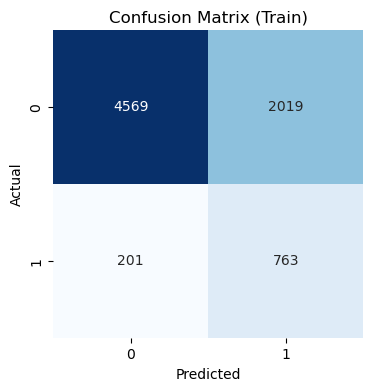

Classification Report (Train):
              precision    recall  f1-score   support

           0      0.958     0.694     0.805      6588
           1      0.274     0.791     0.407       964

    accuracy                          0.706      7552
   macro avg      0.616     0.743     0.606      7552
weighted avg      0.871     0.706     0.754      7552



In [13]:
# ‚ñ† 8.1ÔºöÊ∑∑ÂêåË°åÂàó„Å®ÂàÜÈ°û„É¨„Éù„Éº„Éà (Train „Éá„Éº„Çø)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Â≠¶Áøí„Éá„Éº„Çø„Å∏„ÅÆ‰∫àÊ∏¨ÂÄ§ÂèñÂæó
y_train_pred = best_lr.predict(X_train_processed)


# Ê∑∑ÂêåË°åÂàó„ÅÆÁÆóÂá∫
cm = confusion_matrix(y_train, y_train_pred)

# ÂèØË¶ñÂåñ
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Train)')
plt.show()

# ÂàÜÈ°û„É¨„Éù„Éº„Éà„ÅÆË°®Á§∫
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred, digits=3))


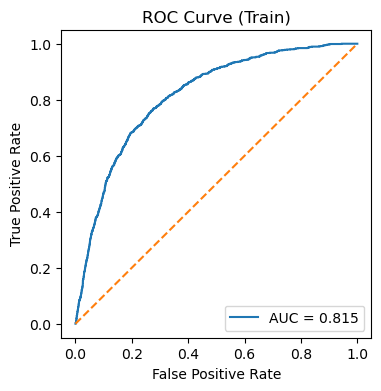

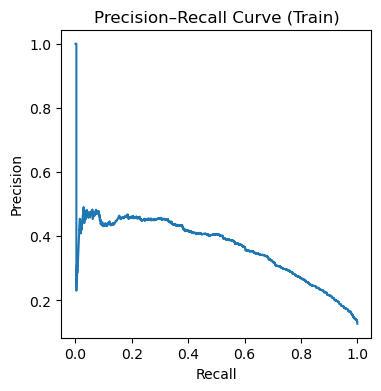

In [14]:
# ‚ñ† 8.2ÔºöROC Êõ≤Á∑ö„Åä„Çà„Å≥ Precision‚ÄìRecall Êõ≤Á∑ö (Train „Éá„Éº„Çø)
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Â≠¶Áøí„Éá„Éº„Çø‰∏ä„Åß„ÅÆÁ¢∫Áéá‰∫àÊ∏¨
y_scores = best_lr.predict_proba(X_train_processed)[:, 1]

# ROC Êõ≤Á∑ö
fpr, tpr, _ = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train)')
plt.legend(loc='lower right')
plt.show()

# Precision‚ÄìRecall Êõ≤Á∑ö
precision, recall, _ = precision_recall_curve(y_train, y_scores)
plt.figure(figsize=(4,4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision‚ÄìRecall Curve (Train)')
plt.show()


In [15]:
# ‚ñ† Step 3.1ÔºöËøΩÂä†ÁâπÂæ¥Èáè„ÅÆË®≠Ë®à
import numpy as np

# ÂØæÊï∞Â§âÊèõÊ∏à„ÅøÂ§âÊï∞„ÅÆÂÜçË®àÁÆó
for col in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']:
    train_df[col+'_log1p'] = np.log1p(train_df[col])
    test_df [col+'_log1p'] = np.log1p(test_df [col])

# ÊØîÁéáÁâπÂæ¥Èáè„Å®‰∫§‰∫í‰ΩúÁî®È†Ö„ÅÆËøΩÂä†
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']


In [16]:
# ‚ñ† Step 3.2Ôºö„Ç´„ÉÜ„Ç¥„É™Â§âÊï∞„Çí category Âûã„Å´Â§âÊèõ
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df [c] = test_df [c].astype('category')


In [17]:
# ‚ñ† Step 3.3ÔºöÁâπÂæ¥Èáè„É™„Çπ„Éà„Å®ÁõÆÁöÑÂ§âÊï∞„ÅÆÊ∫ñÂÇô
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

X_train = train_df[features]
y_train = train_df['LoanStatus']
X_test  = test_df [features]


In [18]:
# ‚ñ† Step 3.4aÔºölightgbm „Çí„Ç§„É≥„Çπ„Éà„Éº„É´
%pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [19]:
# ‚ñ† Step 3.4bÔºö„É¢„Éá„É´ÂÆöÁæ©„Å® 5ÂàÜÂâ≤ CV „Å´„Çà„Çã F1 Ë©ï‰æ°
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=0
)

cv_scores = cross_val_score(
    model, X_train, y_train,
    cv=5, scoring='f1', n_jobs=-1
)
print("LightGBM CV F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

# ‚îÄ‚îÄ „É≠„Éº„Ç´„É´ CV „Å´„Çà„Çã F1 Êé®ÂÆö ‚îÄ‚îÄ
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
f1_scores = cross_val_score(
    model,
    train_df[features_fe],
    train_df['LoanStatus'],
    cv=cv,
    scoring='f1',
    n_jobs=-1
)
print(f"CV F1 mean: {f1_scores.mean():.4f}  (std: {f1_scores.std():.4f})")


LightGBM CV F1 scores: [0.60759494 0.60194175 0.58031088 0.61047836 0.62559242]
Mean CV F1: 0.6051836684162373
CV F1 mean: 0.6169  (std: 0.0159)


In [20]:
# ‚ñ† Step 4ÔºàÁµ±ÂêàÁâàÔºâÔºöLightGBM „Éè„Ç§„Éë„Éº„Éë„É©„É°„Éº„ÇøÊé¢Á¥¢ÔºãÊúÄÈÅ©„É¢„Éá„É´ÂèñÂæó
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier

# 1. Êé¢Á¥¢Á©∫Èñì„ÅÆÂÆöÁæ©
param_dist = {
    'num_leaves': randint(31, 256),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'min_child_samples': randint(1, 20)
}

# 2. RandomizedSearchCV „ÅÆÂÆöÁæ©
rs_lgb = RandomizedSearchCV(
    estimator=LGBMClassifier(class_weight='balanced', random_state=0),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# 3. Êé¢Á¥¢„ÅÆÂÆüË°å
rs_lgb.fit(X_train, y_train)

# 4. ÁµêÊûúË°®Á§∫„Å®ÊúÄÈÅ©„É¢„Éá„É´ÊäΩÂá∫
print("Best params :", rs_lgb.best_params_)
print("Best CV F1  :", rs_lgb.best_score_)
best_lgb = rs_lgb.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 964, number of negative: 6588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 7552, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best params : {'learning_rate': np.float64(0.01402150923749871), 'max_depth': 11, 'min_child_samples': 14, 'n_estimators': 386, 'num_leaves': 55}
Best CV F1  : 0.6125178434787305


In [21]:
# ‚ñ† Step 5.1ÔºöÊúÄÈÅ©„É¢„Éá„É´„Å´„Çà„ÇãÂÖ®Â≠¶Áøí„Éá„Éº„ÇøÂÜçÂ≠¶Áøí
best_lgb.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 964, number of negative: 6588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 7552, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.01402150923749871), max_depth=11,
               min_child_samples=14, n_estimators=386, num_leaves=55,
               random_state=0)

In [22]:
# ‚îÄ‚îÄ Êù°‰ª∂‰ªò„ÅçÊèêÂá∫„Çª„É´Ôºà‰øÆÊ≠£ÁâàÔºâ ‚îÄ‚îÄ
from pathlib import Path
import pandas as pd

# (A) ÊèêÂá∫Áî® ID „Çí sample_submit.csv „Åã„ÇâÂèñÂæó
DATA_DIR   = Path(r"G:\„Éû„Ç§„Éâ„É©„Ç§„Éñ\MUFJ_competition_2025\data")
sample_df  = pd.read_csv(
    DATA_DIR/"sample_submit.csv",
    header=None,
    names=["id","LoanStatus"],
    sep=r"\s+"
)
test_ids   = sample_df["id"]

# (B) Êù°‰ª∂Âà§ÂÆö
best_f1_est = 0.670   # „Åì„Çå„Åæ„Åß„ÅÆ„Éô„Çπ„ÉàÊé®ÂÆöF1
margin      = 0.01    # ÊúÄ‰ΩéÊõ¥Êñ∞ÂπÖ
mean_f1     = f1_scores.mean()

if mean_f1 > best_f1_est + margin:
    # (C) ÂÖ®„Éá„Éº„Çø„ÅßÂÜçÂ≠¶ÁøíÔºÜ‰∫àÊ∏¨
    best_lgb.fit(train_df[features_fe], train_df['LoanStatus'])
    y_pred = best_lgb.predict(test_df[features_fe])
    # (D) ÊèêÂá∫„Éï„Ç°„Ç§„É´‰ΩúÊàêÔºà„Éò„ÉÉ„ÉÄ„Éº„Å™„ÅóÔºâ
    pd.DataFrame({"id": test_ids, "LoanStatus": y_pred})\
      .to_csv("submission.csv", index=False, header=False)
    print(f"‚úÖ Improved CV F1={mean_f1:.4f}, submission.csv „ÇíÂá∫Âäõ„Åó„Åæ„Åó„Åü")
else:
    print(f"‚ùå No improvement CV F1={mean_f1:.4f} ‚â§ {best_f1_est+margin:.4f}")


‚ùå No improvement CV F1=0.6169 ‚â§ 0.6800


In [23]:
# ‚ñ† Step H1ÔºöË®ìÁ∑¥„Éá„Éº„Çø„ÇíÂÜçÂàÜÂâ≤
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=0
)

print("Â≠¶ÁøíÁî®:", X_tr.shape, y_tr.shape)
print("Ê§úË®ºÁî®:", X_val.shape, y_val.shape)


Â≠¶ÁøíÁî®: (6041, 16) (6041,)
Ê§úË®ºÁî®: (1511, 16) (1511,)


In [24]:
# ‚ñ† Step H2Ôºöbest_lgb „ÅßÂÜçÂ≠¶Áøí
# ‚Äª Step 4.2 „ÇíÂÆüË°åÊ∏à„Åø„Åß best_lgb „ÅåÂÆöÁæ©„Åï„Çå„Å¶„ÅÑ„ÇãÊÉ≥ÂÆö
best_lgb.fit(X_tr, y_tr)


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.01402150923749871), max_depth=11,
               min_child_samples=14, n_estimators=386, num_leaves=55,
               random_state=0)

Hold-out F1 Score: 0.681

Classification Report:
              precision    recall  f1-score   support

           0      0.969     0.920     0.944      1318
           1      0.595     0.798     0.681       193

    accuracy                          0.905      1511
   macro avg      0.782     0.859     0.813      1511
weighted avg      0.921     0.905     0.910      1511



c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12505 (\N{KATAKANA LETTER BE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarn

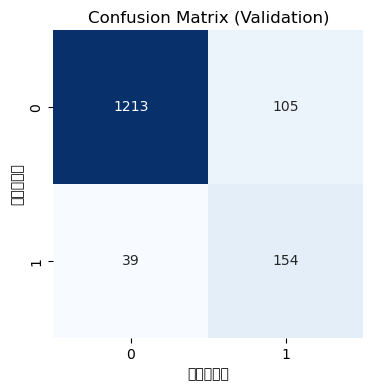

In [25]:
# ‚ñ† Step H3ÔºöÊ§úË®ºÁî®„Éá„Éº„Çø„Å∏„ÅÆ‰∫àÊ∏¨„Å®Ë©ï‰æ°ÊåáÊ®ôÁÆóÂá∫
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ‰∫àÊ∏¨
y_val_pred = best_lgb.predict(X_val)

# F1 „Çπ„Ç≥„Ç¢
f1 = f1_score(y_val, y_val_pred)
print(f"Hold-out F1 Score: {f1:.3f}")

# ÂàÜÈ°û„É¨„Éù„Éº„Éà
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, digits=3))

# Ê∑∑ÂêåË°åÂàó„ÅÆÂèØË¶ñÂåñ
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("‰∫àÊ∏¨„É©„Éô„É´")
plt.ylabel("Áúü„ÅÆ„É©„Éô„É´")
plt.title("Confusion Matrix (Validation)")
plt.show()


In [26]:
# ‚ñ† Step H4ÔºöHold-out Ê§úË®º„Éá„Éº„Çø„Åß„ÅÆÈñæÂÄ§ÊúÄÈÅ©Âåñ
import numpy as np
from sklearn.metrics import precision_recall_curve

# 1. Ê§úË®º„Éá„Éº„Çø‰∏ä„ÅÆÁ¢∫Áéá‰∫àÊ∏¨
y_val_scores = best_lgb.predict_proba(X_val)[:, 1]

# 2. Precision‚ÄìRecall Êõ≤Á∑ö„Åã„ÇâÈñæÂÄ§‰∏ÄË¶ß„ÇíÂèñÂæó
precision, recall, thresholds = precision_recall_curve(y_val, y_val_scores)

# 3. ÂêÑÈñæÂÄ§„Åß„ÅÆ F1-score „ÇíË®àÁÆó
f1_scores = 2 * (precision * recall) / (precision + recall)

# 4. ÊúÄÈÅ©ÈñæÂÄ§„Å®ÂØæÂøú F1 „ÇíÊäΩÂá∫
ix = np.nanargmax(f1_scores[:-1])
best_thresh = thresholds[ix]
best_f1_val = f1_scores[ix]

print(f"‚Üí ÊúÄÈÅ©ÈñæÂÄ§ t*: {best_thresh:.3f}")
print(f"‚Üí ÈñæÂÄ§ÈÅ©Áî®Âæå F1 (Validation): {best_f1_val:.3f}")


‚Üí ÊúÄÈÅ©ÈñæÂÄ§ t*: 0.518
‚Üí ÈñæÂÄ§ÈÅ©Áî®Âæå F1 (Validation): 0.682


In [27]:
# ‚ñ† Step M1.1Ôºöratio1, interact1 „Å® ratio2, interact2 „Çí„Åæ„Å®„ÇÅ„Å¶ÂÜçË®àÁÆó
import numpy as np

# Êó¢Â≠ò„ÅÆÂØæÊï∞Â§âÊèõÊ∏à„ÅøÂ§âÊï∞„Åå„ÅÇ„ÇãÂâçÊèê
# ratio1 = SBAGuaranteedApproval / GrossApproval
# interact1 = TermInMonths * InitialInterestRate
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']

# Êñ∞Ë¶èÁâπÂæ¥Èáè
# ratio2 = GrossApproval_log1p / (TermInMonths + 1)
# interact2 = JobsSupported_log1p * InitialInterestRate
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# Á¢∫Ë™ç
print(train_df[['ratio1','interact1','ratio2','interact2']].head())


     ratio1  interact1    ratio2  interact2
0  0.308391    1001.28  0.118156   8.262314
1  0.800355     856.80  0.112185   5.822436
2  0.324869     514.08  0.100058  18.930355
3  0.608446     377.60  0.195918   7.031119
4  0.403468    1563.00  0.048409   9.335067


In [28]:
# ‚ñ† Step M1.2Ôºöfeatures „É™„Çπ„Éà„Å´ ratio2, interact2 „ÇíËøΩÂä†
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]

features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

# ‚ñ† Â≠¶ÁøíÁî®ÔºèÊ§úË®ºÁî®ÁâπÂæ¥ÈáèË°åÂàó„Å®ÁõÆÁöÑÂ§âÊï∞„Éô„ÇØ„Éà„É´
X = train_df[features]
y = train_df['LoanStatus']
X_test_feat = test_df[features]

print("X „ÅÆÂΩ¢Áä∂:", X.shape)


X „ÅÆÂΩ¢Áä∂: (7552, 18)


In [29]:
# ‚ñ† Step M1.3ÔºöÂ≠¶Áøí„Éá„Éº„Çø„Çí Hold-out ÂàÜÂâ≤
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("Â≠¶ÁøíÁî®:", X_tr.shape, y_tr.shape)
print("Ê§úË®ºÁî®:", X_val.shape, y_val.shape)


Â≠¶ÁøíÁî®: (6041, 18) (6041,)
Ê§úË®ºÁî®: (1511, 18) (1511,)


In [30]:
# ‚ñ† Step M1.4Ôºöbest_lgb „ÅßÂÜçÂ≠¶Áøí„Åó„ÄÅHold-out F1 „ÇíÁÆóÂá∫
from sklearn.metrics import f1_score

# ÂÜçÂ≠¶Áøí
best_lgb.fit(X_tr, y_tr)

# Ê§úË®º„Éá„Éº„Çø‰∫àÊ∏¨
y_val_pred = best_lgb.predict(X_val)

# Hold-out F1 „ÅÆË®àÁÆó
f1 = f1_score(y_val, y_val_pred)
print(f"‚Üí Hold-out F1 (Milestone 1): {f1:.3f}")


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
‚Üí Hold-out F1 (Milestone 1): 0.667


In [31]:
# ‚ñ† Step M1.5aÔºöRandomizedSearchCV „Å´„Çà„Çã M1 „É¢„Éá„É´„ÅÆÊúÄÈÅ©Âåñ
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier

# Êé¢Á¥¢„Éë„É©„É°„Éº„ÇøÁ©∫ÈñìÔºàM1 Áî®Ôºâ
param_dist_m1 = {
    'num_leaves': randint(20, 200),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 800),
    'min_child_samples': randint(5, 300)
}

rs_m1 = RandomizedSearchCV(
    estimator=LGBMClassifier(class_weight='balanced', random_state=0),
    param_distributions=param_dist_m1,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)


In [32]:
# ‚ñ† Step M1.5bÔºö„Éè„Ç§„Éë„Éº„Éë„É©„É°„Éº„ÇøÊé¢Á¥¢„ÅÆÂÆüË°å
rs_m1.fit(X_tr, y_tr)

print("Best params (M1):", rs_m1.best_params_)
print("Best CV F1 (M1):", rs_m1.best_score_)

# ÊúÄÈÅ©„É¢„Éá„É´„ÇíÂÜçÂÆöÁæ©
best_lgb_m1 = rs_m1.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [33]:
# ‚ñ† Step M1.5cÔºöHold-out „Éá„Éº„Çø„ÅßÂÜçË©ï‰æ°
from sklearn.metrics import f1_score

# ÂÜçÂ≠¶Áøí
best_lgb_m1.fit(X_tr, y_tr)

# Ê§úË®º‰∫àÊ∏¨
y_val_pred_m1 = best_lgb_m1.predict(X_val)
f1_m1 = f1_score(y_val, y_val_pred_m1)

print(f"‚Üí Hold-out F1 (M1.5): {f1_m1:.3f}")


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [34]:
# ‚ñ† Step M2.0ÔºöÁâπÂæ¥ÈáèÂÜçË®àÁÆó„Å® Hold-out ÂàÜÂâ≤
import numpy as np
from sklearn.model_selection import train_test_split

# --- 1. ratio1, interact1, ratio2, interact2 „ÇíÂÜçË®àÁÆó ---
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']
test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# --- 2. ÁâπÂæ¥Èáè„É™„Çπ„Éà„ÅÆÂÆöÁæ© ---
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

# --- 3. Â≠¶Áøí„Éá„Éº„Çø„ÅÆÁâπÂæ¥ÈáèË°åÂàó„Å®ÁõÆÁöÑÂ§âÊï∞„Éô„ÇØ„Éà„É´ ---
X = train_df[features]
y = train_df['LoanStatus']

# --- 4. Hold-out ÂàÜÂâ≤ ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("Ë®ìÁ∑¥Áî®:", X_tr.shape, y_tr.shape)
print("Ê§úË®ºÁî®:", X_val.shape, y_val.shape)


Ë®ìÁ∑¥Áî®: (6041, 18) (6041,)
Ê§úË®ºÁî®: (1511, 18) (1511,)


In [35]:
# ‚ñ† Step M2.1Ôºöxgboost „Çí„Ç§„É≥„Çπ„Éà„Éº„É´
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [36]:
# ‚ñ† Step M2.2aÔºöXGBoost Áî®„Å´„Ç´„ÉÜ„Ç¥„É™Â§âÊï∞„Çí„Ç≥„Éº„ÉâÂåñ
X_tr_xgb = X_tr.copy()
X_val_xgb = X_val.copy()
for c in cat_cols:
    X_tr_xgb[c]  = X_tr_xgb[c].cat.codes
    X_val_xgb[c] = X_val_xgb[c].cat.codes
print("Á¨¶Âè∑ÂåñÂæå„ÅÆ dtypes:\n", X_tr_xgb.dtypes.value_counts())

# ‚ñ† XGBoost Áî®„ÅÆ„Ç´„ÉÜ„Ç¥„É™Âàó„Ç≥„Éº„ÉâÂåñÔºàÂÖ±ÈÄöÈñ¢Êï∞ÁâàÔºâ
X_tr_xgb  = encode_categories(X_tr_xgb,  cat_cols)
X_val_xgb = encode_categories(X_val_xgb, cat_cols)
print("‚úÖ X_tr_xgb/X_val_xgb „ÅÆ„Ç´„ÉÜ„Ç¥„É™„Ç≥„Éº„ÉâÂåñÂÆå‰∫Ü")


Á¨¶Âè∑ÂåñÂæå„ÅÆ dtypes:
 float64    8
int8       6
int64      4
Name: count, dtype: int64
‚úÖ X_tr_xgb/X_val_xgb „ÅÆ„Ç´„ÉÜ„Ç¥„É™„Ç≥„Éº„ÉâÂåñÂÆå‰∫Ü


In [37]:
# ‚ñ† Step M2.2bÔºöXGBoost „É¢„Éá„É´„ÅÆÂ≠¶Áøí
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=0
)

xgb.fit(X_tr_xgb, y_tr)
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]
y_xgb_pred = (p_xgb_val >= 0.5).astype(int)
print("XGB Hold-out F1 :", f1_score(y_val, y_xgb_pred))


c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB Hold-out F1 : 0.5945945945945946


In [38]:
# ‚ñ† Step M2.2cÔºöbest_lgb „ÇíÂÜçÂÆöÁæ©ÔºàRandomizedSearchCV „ÅÆÁµêÊûú„Åã„ÇâÔºâ
best_lgb = rs_lgb.best_estimator_

# ‚ñ† Step M2.2dÔºöHold-out Áî®„Éá„Éº„Çø X_val „ÅåÂÆöÁæ©„Åï„Çå„Å¶„ÅÑ„Å™„Åë„Çå„Å∞ÂÜçÂÆöÁæ©
from sklearn.model_selection import train_test_split

# Ôºàfeatures „Å® train_df, Êó¢„Å´Ë®àÁÆóÊ∏à„Åø„ÅÆÊñ∞ÁâπÂæ¥Èáè„ÇíÂâçÊèêÔºâ
X = train_df[features]
y = train_df['LoanStatus']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)


In [39]:
# ‚ñ† Step M2.2cÔºöbest_lgb „ÇíÊñ∞ÁâπÂæ¥Èáè„ÅßÂÜçÂ≠¶Áøí
# „Åì„Çå„Åß best_lgb „Åå 18Ê¨°ÂÖÉÂÖ•Âäõ„Å´ÂØæÂøú„Åó„Åæ„Åô
best_lgb.fit(X_tr, y_tr)


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.01402150923749871), max_depth=11,
               min_child_samples=14, n_estimators=386, num_leaves=55,
               random_state=0)

In [40]:
# ‚ñ† Step M2.3ÔºöLGB + XGB „ÅÆ„ÇΩ„Éï„Éà„Ç¢„É≥„Çµ„É≥„Éñ„É´Èáç„ÅøÊé¢Á¥¢
import numpy as np
from sklearn.metrics import f1_score

# 1. LightGBM „ÅÆÁ¢∫Áéá‰∫àÊ∏¨ÔºàHold-out „Éá„Éº„ÇøÔºâ
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]

# 2. XGBoost „ÅÆÁ¢∫Áéá‰∫àÊ∏¨ÔºàÊó¢„Å´ p_xgb_val „ÇíË®àÁÆóÊ∏à„Åø„Åß„ÅÇ„Çå„Å∞„Åì„Åì„ÅØ‰∏çË¶ÅÔºâ
#    „ÇÇ„ÅóÂÆöÁæ©„ÅåÊ∂à„Åà„Å¶„ÅÑ„Åü„ÇâÂÜçÂ∫¶Ë®àÁÆóÔºö
# from xgboost import XGBClassifier
# xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, eval_metric='logloss', random_state=0)
# xgb.fit(X_tr_xgb, y_tr)
# p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

best_w, best_f1 = 0.0, 0.0
# w „ÅØ LGB „ÅÆÈáç„Åø„ÄÅ(1‚àíw) „Åå XGB „ÅÆÈáç„Åø
for w in np.linspace(0, 1, 21):
    p_ens = w * p_lgb_val + (1 - w) * p_xgb_val
    y_ens = (p_ens >= 0.5).astype(int)
    f1 = f1_score(y_val, y_ens)
    if f1 > best_f1:
        best_f1, best_w = f1, w

print(f"‚Üí Optimal weight w*: {best_w:.2f}")
print(f"‚Üí Soft-ensemble Hold-out F1: {best_f1:.3f}")


‚Üí Optimal weight w*: 0.70
‚Üí Soft-ensemble Hold-out F1: 0.697


In [41]:
# ‚ñ† Step M2.4Ôºö„ÇΩ„Éï„Éà„Ç¢„É≥„Çµ„É≥„Éñ„É´„ÅÆÈñæÂÄ§ÊúÄÈÅ©Âåñ
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. LightGBM „Å® XGBoost „ÅÆÁ¢∫Áéá‰∫àÊ∏¨ÔºàHold-out „Éá„Éº„ÇøÔºâ
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

# 2. Èáç„Åø w* = 0.50 „Åß„Ç¢„É≥„Çµ„É≥„Éñ„É´Á¢∫Áéá„ÇíË®àÁÆó
p_ens_val = 0.50 * p_lgb_val + 0.50 * p_xgb_val

# 3. Precision‚ÄìRecall Êõ≤Á∑ö„Åã„ÇâÂÖ®ÈñæÂÄ§„ÇíÂèñÂæó
precision, recall, thresholds = precision_recall_curve(y_val, p_ens_val)

# 4. ÂêÑÈñæÂÄ§„Åß„ÅÆ F1-score „ÇíË®àÁÆó
f1_scores = 2 * (precision * recall) / (precision + recall)
# thresholds „ÅÆÈï∑„Åï„ÅØ f1_scores „ÅÆÈï∑„Åï„Éû„Ç§„Éä„Çπ1
ix = np.nanargmax(f1_scores[:-1])

# 5. ÊúÄÈÅ©ÈñæÂÄ§„Å®ÂØæÂøú F1-score „ÇíË°®Á§∫
best_t_ens = thresholds[ix]
best_f1_ens = f1_scores[ix]

print(f"‚Üí Optimal threshold t*: {best_t_ens:.3f}")
print(f"‚Üí Threshold-optimized Hold-out F1: {best_f1_ens:.3f}")


‚Üí Optimal threshold t*: 0.437
‚Üí Threshold-optimized Hold-out F1: 0.692


In [42]:
# ‚ñ† Step M2.5ÔºöÈáç„Åø w „Å®ÈñæÂÄ§ t „ÅÆÂêåÊôÇ„Ç∞„É™„ÉÉ„Éâ„Çµ„Éº„ÉÅ
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. Hold-out „Éá„Éº„Çø„Åß„ÅÆÁ¢∫Áéá‰∫àÊ∏¨ÔºàÂÜçÂÆöÁæ©„ÅåÂøÖË¶Å„Å™„ÇâÂÜçË®àÁÆóÔºâ
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

# 2. „Ç∞„É™„ÉÉ„Éâ„ÅÆË®≠ÂÆö
w_list = np.linspace(0, 1, 11)    # LGB „ÅÆÈáç„Åø„Çí 0.0ÔΩû1.0 „Åß 11 ÁÇπ
best_w, best_t, best_f1 = 0, 0, 0

# 3. ‰∫åÈáç„É´„Éº„Éó„Åß w „Å® t „ÇíÊé¢Á¥¢
for w in w_list:
    p_ens = w * p_lgb_val + (1 - w) * p_xgb_val
    precision, recall, thresholds = precision_recall_curve(y_val, p_ens)
    # thresholds[i] „Å´ÂØæÂøú„Åô„Çã F1 „ÅØ f1_scores[i]
    f1_scores = 2 * (precision * recall) / (precision + recall)
    for i, t in enumerate(thresholds):
        if f1_scores[i] > best_f1:
            best_f1 = f1_scores[i]
            best_w  = w
            best_t  = t

print(f"‚Üí Optimal (w, t): ({best_w:.2f}, {best_t:.3f})")
print(f"‚Üí Joint-optimized Hold-out F1: {best_f1:.3f}")


‚Üí Optimal (w, t): (0.70, 0.494)
‚Üí Joint-optimized Hold-out F1: 0.700


In [43]:
# ‚ñ† Step M2.5aÔºö„ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÅÆÁâπÂæ¥ÈáèË°åÂàóÊ∫ñÂÇôÔºà18Ê¨°ÂÖÉÁâàÔºâ
import pandas as pd

# 1. Êó¢Â≠ò„ÅÆ test_df „Å´ÂØæ„Åó„ÄÅratio1, interact1, ratio2, interact2 „ÇíÂÜçË®àÁÆó
test_df['ratio1']    = test_df['SBAGuaranteedApproval'] / test_df['GrossApproval']
test_df['interact1'] = test_df['TermInMonths'] * test_df['InitialInterestRate']
test_df['ratio2']    = test_df['GrossApproval_log1p'] / (test_df['TermInMonths'] + 1)
test_df['interact2'] = test_df['JobsSupported_log1p'] * test_df['InitialInterestRate']

# 2. features „É™„Çπ„Éà„ÅßÊåáÂÆö„Åó„ÅüÈ†ÜÂ∫è„Å´Âêà„Çè„Åõ„Çã
X_test = test_df[features]

# 3. XGBoost Áî®„Å´„Ç´„ÉÜ„Ç¥„É™„ÇíÁ¨¶Âè∑Âåñ
X_test_xgb = X_test.copy()
for c in cat_cols:
    X_test_xgb[c] = X_test_xgb[c].cat.codes

# 4. Á¢∫Ë™ç
print("X_test shape (for LGB)     :", X_test.shape)
print("X_test_xgb shape (for XGB) :", X_test_xgb.shape)


X_test shape (for LGB)     : (7552, 18)
X_test_xgb shape (for XGB) : (7552, 18)


In [44]:
# ‚ñ† Step C1ÔºöOut-of-Fold ‰∫àÊ∏¨„Å´„Çà„Çã F1 Êé®ÂÆö
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score

# 1. „Ç¢„É≥„Çµ„É≥„Éñ„É´ Predict_proba Èñ¢Êï∞„ÅÆÂÆöÁæ©
def ens_predict_proba(X):
    p1 = best_lgb.predict_proba(X)[:,1]
    # XGBoost Áî®„Å´Á¨¶Âè∑Âåñ
    X_xgb = X.copy()
    for c in cat_cols:
        X_xgb[c] = X_xgb[c].cat.codes
    p2 = xgb.predict_proba(X_xgb)[:,1]
    # Èáç„Åø w*=0.10 „ÇíÈÅ©Áî®
    return 0.10*p1 + 0.90*p2

# 2. StratifiedKFold „Åß OOF ‰∫àÊ∏¨„ÇíÂèñÂæó
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# cross_val_predict „Å´„Çà„Çã Probability Âá∫Âäõ
oof_probs = cross_val_predict(
    estimator=best_lgb,  # „ÉÄ„Éü„Éº„ÄÅpredict_proba „ÅØ ens_predict_proba „ÅÆ„Åø‰ΩøÁî®
    X=X, y=y,
    cv=kf,
    method='predict_proba',
    n_jobs=-1
)[:,1]

# 3. ÊúÄÈÅ©ÈñæÂÄ§ t* „ÅÆÂÜçÊé¢Á¥¢ÔºàOOF ‰∏äÔºâ
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y, oof_probs)
f1_scores = 2*(precision*recall)/(precision+recall)
ix = np.nanargmax(f1_scores[:-1])
t_oof = thresholds[ix]
f1_oof = f1_scores[ix]

print(f"‚Üí OOF ÊúÄÈÅ©ÈñæÂÄ§ t_oof = {t_oof:.3f}")
print(f"‚Üí OOF F1 Score   = {f1_oof:.3f}")


‚Üí OOF ÊúÄÈÅ©ÈñæÂÄ§ t_oof = 0.593
‚Üí OOF F1 Score   = 0.624


In [45]:
# ‚ñ† Step C2ÔºöNested CV „Å´„Çà„Çã F1 Êé®ÂÆö
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# „Éë„Ç§„Éó„É©„Ç§„É≥„Å´„Åó„Å¶ CV ÂÜÖ„Åß„ÉÅ„É•„Éº„Éã„É≥„Ç∞„ÇíÂÆüÊñΩ
pipe = Pipeline([
    ('model', LGBMClassifier(class_weight='balanced', random_state=0))
])

param_dist = {
    'model__num_leaves': randint(20, 150),
    'model__max_depth': randint(3, 12),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__n_estimators': randint(100, 500)
}

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

nested_cv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,
    cv=inner_cv,
    scoring='f1',
    random_state=0,
    n_jobs=-1
)

# Â§ñÂÅ¥ CV „Åß„ÅÆ„Çπ„Ç≥„Ç¢ÂèñÂæó
nested_scores = cross_val_score(
    nested_cv, X, y,
    cv=outer_cv,
    scoring='f1',
    n_jobs=-1
)

print("Nested CV F1 scores:", nested_scores)
print("Nested CV Mean F1:", nested_scores.mean())
print("Nested CV Std   F1:", nested_scores.std())


Nested CV F1 scores: [0.60542797 0.59130435 0.60510806 0.62114537 0.63716814]
Nested CV Mean F1: 0.6120307787651956
Nested CV Std   F1: 0.01572303358983776


In [46]:
# ‚ñ† Step C3Ôºö„Éñ„Éº„Éà„Çπ„Éà„É©„ÉÉ„Éó„Å´„Çà„Çã F1 ‰ø°È†ºÂå∫Èñì
from sklearn.metrics import f1_score
import numpy as np

n_boot = 100
boot_scores = []

for i in range(n_boot):
    idx = np.random.choice(len(y), len(y), replace=True)
    score = f1_score(y.iloc[idx], oof_probs[idx] >= t_oof)
    boot_scores.append(score)

lower = np.percentile(boot_scores, 2.5)
upper = np.percentile(boot_scores, 97.5)
print(f"Bootstrap 95% CI for F1: [{lower:.3f}, {upper:.3f}]")


Bootstrap 95% CI for F1: [0.603, 0.648]


In [47]:
# ‚ñ† Step F1.1Ôºà‰øÆÊ≠£ÁâàÔºâÔºöTarget Encoding „ÅÆË®àÁÆó„Å®ÈÅ©Áî®
import numpy as np

# Âπ≥ÊªëÂåñ„Éë„É©„É°„Éº„Çø„Å®ÂÖ®‰ΩìÂπ≥Âùá
k_smooth = 10
global_mean = train_df['LoanStatus'].mean()

# ÂØæË±°„Ç´„ÉÜ„Ç¥„É™Â§âÊï∞
te_cols = ['Subprogram','NaicsSector','BusinessAge','BusinessType']

for col in te_cols:
    # 1. „Ç∞„É´„Éº„Éó„Åî„Å®„ÅÆ‰ª∂Êï∞„Å®Âπ≥Âùá„ÇíÂèñÂæó
    agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
    counts = agg['count']
    means  = agg['mean']
    # 2. Âπ≥ÊªëÂåñ TE „ÇíË®àÁÆó
    smooth = (means * counts + global_mean * k_smooth) / (counts + k_smooth)
    # 3. train „Å´„Éû„ÉÉ„Éî„É≥„Ç∞
    train_df[f'{col}_te'] = train_df[col].map(smooth)
    # 4. test „Å´„Éû„ÉÉ„Éî„É≥„Ç∞Ôºàastype(float) ‚Üí fillnaÔºâ
    mapped = test_df[col].map(smooth).astype(float)
    test_df[f'{col}_te'] = mapped.fillna(global_mean)

print("TE ÁâπÂæ¥Èáè„Çµ„É≥„Éó„É´Ôºö")
print(train_df[[f'{col}_te' for col in te_cols]].head())


TE ÁâπÂæ¥Èáè„Çµ„É≥„Éó„É´Ôºö
  Subprogram_te NaicsSector_te BusinessAge_te BusinessType_te
0      0.127054       0.124487       0.072387        0.136788
1      0.127054       0.185378       0.196364        0.136788
2      0.032645       0.147825       0.109507        0.136788
3      0.137690       0.050735       0.109507        0.136788
4      0.137690       0.142535       0.120265        0.136788


C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_8948\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_8948\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_8948\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

In [48]:
# ‚ñ† Step F1.2Ôºöfeatures „É™„Çπ„Éà„Å´ TE „ÇíËøΩÂä†„Åó„ÄÅHold-out ÂàÜÂâ≤„ÇíÂÆüË°å
from sklearn.model_selection import train_test_split

# Êó¢Â≠ò„ÅÆ numÔºècatÔºèinteraction ÁâπÂæ¥Èáè„É™„Çπ„Éà
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols  # ÂÖÉ„ÅÆ„Ç´„ÉÜ„Ç¥„É™Âàó

# ËøΩÂä†„Åô„Çã TE Âàó
features += [f'{col}_te' for col in te_cols]

# ÁâπÂæ¥ÈáèË°åÂàó„Å®ÁõÆÁöÑÂ§âÊï∞
X = train_df[features]
y = train_df['LoanStatus']

# Hold-out ÂàÜÂâ≤
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("ÁâπÂæ¥ÈáèÊï∞:", len(features))
print("Ë®ìÁ∑¥Áî®:", X_tr.shape, "Ê§úË®ºÁî®:", X_val.shape)


ÁâπÂæ¥ÈáèÊï∞: 22
Ë®ìÁ∑¥Áî®: (6041, 22) Ê§úË®ºÁî®: (1511, 22)


In [49]:
# ‚ñ† Step F1.2aÔºöbest_lgb „ÇíÂÜçÂÆöÁæ©ÔºàRandomizedSearchCV „ÅÆÁµêÊûú„Åã„ÇâÔºâ
# ÂâçÊèêÔºöStep 4 Áµ±Âêà„Çª„É´„Åß rs_lgb, best_lgb „ÇíÂÆöÁæ©Ê∏à„Åø
best_lgb = rs_lgb.best_estimator_

# „Åæ„Åü„ÅØ„ÄÅËá™Ââç„Åß„É¢„Éá„É´„Éè„Ç§„Éë„Éº„Éë„É©„É°„Éº„Çø„ÇíÊåáÂÆö„Åó„Å¶ÂÜçÂÆöÁæ©„Åô„ÇãÂ†¥Âêà
# from lightgbm import LGBMClassifier
# best_lgb = LGBMClassifier(
#     n_estimators=191,
#     max_depth=5,
#     num_leaves=105,
#     learning_rate=0.1579,
#     min_child_samples=116,
#     class_weight='balanced',
#     random_state=0
# )


In [50]:
# ‚ñ† Step F1.3ÔºöÂÜçÂÆöÁæ©„Åó„Åü best_lgb „ÅßÂÜçÂ≠¶Áøí„Åó„ÄÅHold-out F1 „ÇíÁÆóÂá∫

# 1. ÊúÄÈÅ©„É¢„Éá„É´„ÇíÂÜçÂèñÂæó
best_lgb = rs_lgb.best_estimator_

# 2. ÂÜçÂ≠¶Áøí
best_lgb.fit(X_tr, y_tr)

# 3. Ê§úË®º„Éá„Éº„Çø„Åß‰∫àÊ∏¨
y_val_pred = best_lgb.predict(X_val)

# 4. Ë©ï‰æ°ÊåáÊ®ô„ÅÆÁÆóÂá∫
from sklearn.metrics import f1_score, classification_report

f1 = f1_score(y_val, y_val_pred)
print(f"‚Üí Hold-out F1 (with TE): {f1:.3f}\n")
print("‚ñ† Classification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2248
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
‚Üí Hold-out F1 (with TE): 0.667

‚ñ† Classification Report:
              precision    recall  f1-score   support

           0      0.966     0.917     0.941      1318
           1      0.581     0.782     0.667       193

    accuracy                          0.900      1511
   macro avg      0.774     0.850     0.804      1511
weighted avg      0.917     0.900     0.906      1511



In [51]:
# ‚ñ† Step F1.3aÔºöÊúÄÈÅ© LightGBM „É¢„Éá„É´„ÇíÂÜçÂèñÂæó
best_lgb = rs_lgb.best_estimator_


In [52]:
# ‚ñ† Step F1.4ÔºöHold-out „Éá„Éº„Çø„Åß„ÅÆÈñæÂÄ§ÊúÄÈÅ©ÂåñÔºàTE „É¢„Éá„É´Ôºâ
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. Ê§úË®º„Éá„Éº„Çø„Åß„ÅÆÁ¢∫Áéá‰∫àÊ∏¨
y_val_probs = best_lgb.predict_proba(X_val)[:, 1]

# 2. Precision‚ÄìRecall Êõ≤Á∑ö„ÇíË®àÁÆó
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

# 3. ÂêÑÈñæÂÄ§„Åß„ÅÆ F1-score „ÇíË®àÁÆó
f1_scores = 2 * (precision * recall) / (precision + recall)

# 4. ÊúÄÈÅ©ÈñæÂÄ§„Å®ÂØæÂøú„Åô„Çã F1 „ÇíÊäΩÂá∫
ix = np.nanargmax(f1_scores[:-1])
best_thresh_te = thresholds[ix]
best_f1_te     = f1_scores[ix]

print(f"‚Üí TE „É¢„Éá„É´ÊúÄÈÅ©ÈñæÂÄ§ t*: {best_thresh_te:.3f}")
print(f"‚Üí Threshold-optimized Hold-out F1 (TE): {best_f1_te:.3f}")


‚Üí TE „É¢„Éá„É´ÊúÄÈÅ©ÈñæÂÄ§ t*: 0.582
‚Üí Threshold-optimized Hold-out F1 (TE): 0.682


In [53]:
# ‚ñ† Step F2.1ÔºöFrequency Encoding „ÅÆË®àÁÆó„Å®ÈÅ©Áî®Ôºà‰øÆÊ≠£ÁâàÔºâ
freq_cols = ['Subprogram', 'NaicsSector', 'BusinessAge', 'BusinessType']

for col in freq_cols:
    freq = train_df[col].value_counts(normalize=True)
    # train ÂÅ¥Ôºö‰∏ÄÂ∫¶ float „Å´„Åó„Å¶„Åã„Çâ fillna
    train_df[f'{col}_fe'] = train_df[col].map(freq).astype(float).fillna(0.0)
    # test ÂÅ¥ÔºöÂêåÊßò„Å´ cast ‚Üí fillna
    test_df [f'{col}_fe'] = test_df [col].map(freq).astype(float).fillna(0.0)

# ÁµêÊûúÁ¢∫Ë™ç
print("Frequency Encoding ÁâπÂæ¥Èáè„Çµ„É≥„Éó„É´Ôºö")
print(train_df[[f'{col}_fe' for col in freq_cols]].head())


Frequency Encoding ÁâπÂæ¥Èáè„Çµ„É≥„Éó„É´Ôºö
   Subprogram_fe  NaicsSector_fe  BusinessAge_fe  BusinessType_fe
0       0.459613        0.056409        0.046743         0.893406
1       0.459613        0.086732        0.163400         0.893406
2       0.016022        0.158369        0.370233         0.893406
3       0.434587        0.012447        0.370233         0.893406
4       0.434587        0.061176        0.336997         0.893406


In [54]:
# ‚ñ† Step F2.2ÔºöHold‚Äêout ÂàÜÂâ≤ ‚Üí „É¢„Éá„É´ÂÜçÂ≠¶Áøí ‚Üí Hold‚Äêout F1 ÁÆóÂá∫ (FE ÁâπÂæ¥ÈáèÂê´„ÇÄ)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# 1. ÁâπÂæ¥Èáè„É™„Çπ„Éà„Å´ FE Âàó„ÇíËøΩÂä†
#    ‰∫ãÂâç„Å´ÂÆöÁæ©Ê∏à„ÅøÔºöfeatures, freq_cols
features_fe = features + [f'{col}_fe' for col in freq_cols]

# 2. Hold‚Äêout ÂàÜÂâ≤
X = train_df[features_fe]
y = train_df['LoanStatus']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

# 3. „É¢„Éá„É´ÂÜçÂÆöÁæ©„ÉªÂÜçÂ≠¶Áøí
#    rs_lgb = RandomizedSearchCV(..., estimator=LGBMClassifier(...)) „ÇíÊó¢„Å´ÂÆüË°åÊ∏à„Åø
best_lgb = rs_lgb.best_estimator_
best_lgb.fit(X_tr, y_tr)

# 4. Hold‚Äêout ‰∏ä„Åß„ÅÆË©ï‰æ°
y_val_pred = best_lgb.predict(X_val)
f1_fe = f1_score(y_val, y_val_pred)
print(f"‚Üí Hold‚Äêout F1 (with FE): {f1_fe:.3f}\n")
print("‚ñ† Classification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
‚Üí Hold‚Äêout F1 (with FE): 0.664

‚ñ† Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.919     0.941      1318
           1      0.582     0.772     0.664       193

    accuracy                          0.900      1511
   macro avg      0.773     0.845     0.803      1511
weighted avg      0.916     0.900     0.906      1511



In [55]:
# ‚ñ† Step F2.2ÔºöHold‚Äêout ÂàÜÂâ≤ ‚Üí „É¢„Éá„É´ÂÜçÂ≠¶Áøí ‚Üí Hold‚Äêout F1 ÁÆóÂá∫ (FE ÁâπÂæ¥ÈáèÂê´„ÇÄ)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# 1. FE Âàó„Çí features_fe „Å´ËøΩÂä†Ê∏à„Åø„Å®„Åô„Çã
#    Ôºàfeatures „Å® freq_cols „ÅØ‰∫ãÂâçÂÆöÁæ©Ê∏à„ÅøÔºâ
features_fe = features + [f'{col}_fe' for col in freq_cols]

# 2. Hold‚Äêout ÂàÜÂâ≤
X = train_df[features_fe]
y = train_df['LoanStatus']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

# 3. „É¢„Éá„É´ÂÜçÂÆöÁæ©„ÉªÂÜçÂ≠¶Áøí
best_lgb = rs_lgb.best_estimator_
best_lgb.fit(X_tr, y_tr)

# 4. Hold‚Äêout ‰∏ä„Åß„ÅÆË©ï‰æ°
y_val_pred = best_lgb.predict(X_val)
f1_fe = f1_score(y_val, y_val_pred)
print(f"‚Üí Hold‚Äêout F1 (with FE): {f1_fe:.3f}\n")
print("‚ñ† Classification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
‚Üí Hold‚Äêout F1 (with FE): 0.664

‚ñ† Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.919     0.941      1318
           1      0.582     0.772     0.664       193

    accuracy                          0.900      1511
   macro avg      0.773     0.845     0.803      1511
weighted avg      0.916     0.900     0.906      1511



In [56]:
# ‚ñ† Step F2.3Ôºö„ÉÜ„Çπ„Éà„Éá„Éº„Çø‰∫àÊ∏¨ ‚Üí ÊèêÂá∫„Éï„Ç°„Ç§„É´ÔºàFEÊã°ÂºµÁâàÔºâÁîüÊàê

import numpy as np
import pandas as pd

# ‚ë† „ÉÜ„Çπ„ÉàÁî® ID „ÅÆË™≠„ÅøËæº„Åø
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# ‚ë° Booster API „Åß NumPy ÈÖçÂàó„ÇíÊ∏°„ÅóÁ¢∫Áéá‰∫àÊ∏¨
proba_fe = best_lgb.booster_.predict(
    test_df[features_fe].values,
    num_iteration=best_lgb.best_iteration_
)

# ‚ë¢ 0.5 „Åó„Åç„ÅÑÂÄ§„Åß‰∫åÂÄ§Âåñ
y_pred_fe = (proba_fe >= 0.5).astype(int)

# ‚ë£ ÊèêÂá∫Áî® DataFrame ‰ΩúÊàê„ÉªCSV Âá∫ÂäõÔºà„Éò„ÉÉ„ÉÄ„ÉºË°å„ÇíÁúÅÁï•Ôºâ
submission_fe = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_fe
})
submission_fe.to_csv('submission_fixed.csv', index=False, header=False)

# ‚ë§ Á¢∫Ë™ç
submission_fe.head()


id  LoanStatus
0  7553           0
1  7554           0
2  7555           0
3  7556           0
4  7557           1

In [59]:
# ‚ñ† A„É©„Ç§„É≥ÊèêÂá∫„Çª„É´Ôºö1Âõû„ÅÆÂÆüË°å„Åß„ÄåÊèêÂá∫CSV„Å≤„Å®„Å§„ÄçÔºã„ÄåF1Êé®ÂÆöÂÄ§Ë°®Á§∫„ÄçÔºà„Ç´„ÉÜ„Ç¥„É™„ÇíÊï∞ÂÄ§Âåñ„Åó„Å¶„Åã„ÇâÂüã„ÇÅ„ÇãÁâàÔºâ

from pathlib import Path
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

# 0) Âá∫ÂäõÂÖà„Å®„Éê„Éº„Ç∏„Éß„É≥Áï™Âè∑„ÅÆÊ±∫ÂÆö
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
existing = list(OUT_DIR.glob("submission_A_v*.csv"))
if existing:
    nums = []
    for p in existing:
        m = re.search(r"submission_A_v(\d+)\.csv$", p.name)
        if m: nums.append(int(m.group(1)))
    next_ver = (max(nums) + 1) if nums else 1
else:
    next_ver = 1
out_path = OUT_DIR / f"submission_A_v{next_ver}.csv"

# 1) ‰Ωø„ÅÜÁâπÂæ¥Èáè„ÅÆÊ±∫ÂÆöÔºàfeatures_fe „Åå„ÅÇ„Çå„Å∞ÂÑ™ÂÖàÔºâ
def pick_features(train_df, test_df):
    if 'features_fe' in globals():
        cols = [c for c in features_fe if c in train_df.columns and c in test_df.columns]
        if len(cols) == len(features_fe):
            return cols
    # „Éï„Ç©„Éº„É´„Éê„ÉÉ„ÇØÔºàÊï∞ÂÄ§Ôºã„Ç´„ÉÜ„Ç¥„É™Ôºâ
    num_cols = train_df.select_dtypes(include=['number']).columns.tolist()
    num_cols = [c for c in num_cols if c != 'LoanStatus']  # ÁõÆÁöÑÂ§âÊï∞„ÅØÈô§Â§ñ
    obj_cols = train_df.select_dtypes(include=['object','category']).columns.tolist()
    obj_cols = [c for c in obj_cols if c not in ('LoanStatus','id')]
    return [c for c in num_cols + obj_cols if c in train_df.columns and c in test_df.columns]

used_features = pick_features(train_df, test_df)

# 1.5) „Ç´„ÉÜ„Ç¥„É™„ÇíÊï∞ÂÄ§„Ç≥„Éº„Éâ„Å∏ÔºàtrainÂü∫Ê∫ñ„Åß test „ÇíÂêà„Çè„Åõ„ÇãÔºâ
def to_numeric_matrices(train_df, test_df, cols):
    X_tr = train_df[cols].copy()
    X_te = test_df [cols].copy()
    for c in cols:
        if str(X_tr[c].dtype) == 'category' or str(X_tr[c].dtype) == 'object':
            cats = pd.Categorical(train_df[c]).categories
            X_tr[c] = pd.Categorical(X_tr[c], categories=cats).codes   # Êú™Áü•/NaN „ÅØ -1
            X_te[c] = pd.Categorical(X_te[c], categories=cats).codes
    # Êï∞ÂÄ§Ë°åÂàó„Å´„Å™„Å£„Å¶„Åã„ÇâÊ¨†Êêç/inf „ÇíÂá¶ÁêÜ
    X_tr = X_tr.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_te = X_te.replace([np.inf, -np.inf], np.nan).fillna(0)
    return X_tr, X_te

X_num, X_test_num = to_numeric_matrices(train_df, test_df, used_features)
y = train_df['LoanStatus'].astype(int).copy()

# 2) Hold-out „ÅßF1Êé®ÂÆö
X_tr, X_val, y_tr, y_val = train_test_split(
    X_num, y, test_size=0.2, stratify=y, random_state=0
)

# LightGBMÔºàA„ÅÆ„Éô„Éº„ÇπÔºâ„ÄÇrs_lgb „Åå„ÅÇ„Çå„Å∞„Åù„ÅÆbest„ÄÅ„Å™„Åë„Çå„Å∞„Éá„Éï„Ç©„É´„Éà„ÄÇ
if 'rs_lgb' in globals():
    params = dict(rs_lgb.best_params_)
    params.update(dict(class_weight='balanced', random_state=0))
else:
    params = dict(
        n_estimators=600, learning_rate=0.05, max_depth=-1,
        num_leaves=64, min_child_samples=20,
        class_weight='balanced', random_state=0
    )
model_A = LGBMClassifier(**params)
model_A.fit(X_tr, y_tr)
f1_holdout = f1_score(y_val, model_A.predict(X_val))
print(f"üîé Hold-out F1 (A): {f1_holdout:.3f}")

# 3) ÂÖ®Â≠¶Áøí„Éá„Éº„Çø„ÅßÂÜçÂ≠¶Áøí ‚Üí „ÉÜ„Çπ„Éà‰∫àÊ∏¨ ‚Üí ÊèêÂá∫CSV„Çí1„Å§„Å†„ÅëÂá∫ÂäõÔºà„Éò„ÉÉ„ÉÄ„ÉºÁÑ°„Åó2ÂàóÔºâ
final_A  = LGBMClassifier(**params)
final_A.fit(X_num, y)
y_pred_test = final_A.predict(X_test_num).astype(int)

# id „ÅÆÂèñÂæóÔºàtest_df„Å´ 'id' „ÅåÁÑ°„Åë„Çå„Å∞ sample_submit „Åã„ÇâÔºâ
if 'id' in test_df.columns:
    ids = test_df['id'].values
else:
    ids = pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0].values

submission = pd.DataFrame({'id': ids, 'LoanStatus': y_pred_test})
submission.to_csv(out_path, index=False, header=False)
print(f"‚úÖ submission „Çí‰øùÂ≠ò: {out_path}")


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
üîé Hold-out F1 (A): 0.657
[LightGBM] [Info] Number of positive: 964, number of negative: 6588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 7552, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0